In [1]:
%load_ext autoreload 
%autoreload 2

# 05 - Collect Prediction Results

Aggregate the two-day prediction outputs from the 04 notebooks across all markets, then reuse the shared helpers for metrics and plotting.

## Step 1: Imports and paths
Add the project `src/` to the path so the plotting helpers and pipeline utilities are available.

In [2]:
from pathlib import Path
import sys
import pandas as pd

# Resolve project root whether the notebook is launched from the repo root or the Notebooks folder
current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'Notebooks' else current_dir.parent
sys.path.insert(0, str(project_root / 'src'))

from prediction_visuals import (
    build_prediction_path,
    load_prediction_csv,
    dataframe_to_predictions,
    plot_market_predictions,
    load_published_benchmarks_for_horizon,
)
from forecast_pipeline import (
    load_data_from_epftoolbox,
    evaluate_all_models,
)


2025-12-17 15:26:12.747589: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 15:26:12.772522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-17 15:26:12.772546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-17 15:26:12.773105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-17 15:26:12.777070: I tensorflow/core/platform/cpu_feature_guar

## Step 2: Configure markets and horizon
Targets mirror the two-day runs executed in the 04 notebooks.

In [3]:
MARKETS = ['BE', 'DE', 'FR', 'NP', 'PJM']
TARGET_START_DATE = '2016-12-27'
N_DAYS = 2
YEARS_TEST = 2

PREDICTIONS_DIR = project_root / 'predictions'
FORECASTS_DIR = project_root / 'forecasts'
DATASETS_DIR = project_root / 'datasets'

# Derive the end date for filenames and plot titles
TARGET_END_DATE = (pd.to_datetime(TARGET_START_DATE) + pd.Timedelta(days=N_DAYS - 1)).strftime('%Y-%m-%d')

# Confirm the prediction files we will read
prediction_files = {
    market: build_prediction_path(PREDICTIONS_DIR, market, TARGET_START_DATE, TARGET_END_DATE)
    for market in MARKETS
}
prediction_files


{'BE': PosixPath('/home/llinfeng/GitRepo/1_Projects/DianLi_电力/Benchmark1-epftoolbox/predictions/predictions_BE_20161227_to_20161228.csv'),
 'DE': PosixPath('/home/llinfeng/GitRepo/1_Projects/DianLi_电力/Benchmark1-epftoolbox/predictions/predictions_DE_20161227_to_20161228.csv'),
 'FR': PosixPath('/home/llinfeng/GitRepo/1_Projects/DianLi_电力/Benchmark1-epftoolbox/predictions/predictions_FR_20161227_to_20161228.csv'),
 'NP': PosixPath('/home/llinfeng/GitRepo/1_Projects/DianLi_电力/Benchmark1-epftoolbox/predictions/predictions_NP_20161227_to_20161228.csv'),
 'PJM': PosixPath('/home/llinfeng/GitRepo/1_Projects/DianLi_电力/Benchmark1-epftoolbox/predictions/predictions_PJM_20161227_to_20161228.csv')}

## Step 3: Load saved predictions
Read the CSVs produced by the 04 notebooks and keep them in both dataframe and dictionary forms.

In [4]:
market_tables = {}
market_predictions = {}

for market, path in prediction_files.items():
    df = load_prediction_csv(PREDICTIONS_DIR, market, TARGET_START_DATE, TARGET_END_DATE)
    market_tables[market] = df
    market_predictions[market] = dataframe_to_predictions(df)
    print(f"{market}: {df.shape[0]} rows, columns: {list(df.columns)}")


BE: 48 rows, columns: ['Hour', 'actual', 'LEAR_1456', 'LEAR_1092', 'LEAR_84', 'LEAR_56', 'DNN_4years']
DE: 48 rows, columns: ['Hour', 'actual', 'LEAR_1456', 'LEAR_1092', 'LEAR_84', 'LEAR_56', 'DNN_4years']
FR: 48 rows, columns: ['Hour', 'actual', 'LEAR_1456', 'LEAR_1092', 'LEAR_84', 'LEAR_56', 'DNN_4years']
NP: 48 rows, columns: ['Hour', 'actual', 'LEAR_1456', 'LEAR_1092', 'LEAR_84', 'LEAR_56', 'DNN_4years']
PJM: 48 rows, columns: ['Hour', 'actual', 'LEAR_1456', 'LEAR_1092', 'LEAR_84', 'LEAR_56', 'DNN_4years']


In [5]:
# Quick peek at the stacked view across markets
stacked = pd.concat(
    [df.assign(Market=market) for market, df in market_tables.items()],
    ignore_index=True
)
stacked.head()


,Hour,actual,LEAR_1456,LEAR_1092,LEAR_84,LEAR_56,DNN_4years,Market
0,0,35.30,38.767209,36.509413,29.182093,34.340114,40.991119,BE
1,1,38.33,34.171141,32.943317,33.720605,35.348306,40.973648,BE
2,2,41.04,33.045628,31.144720,33.393908,34.926796,40.942097,BE
3,3,34.62,30.701375,28.834301,31.601553,31.091790,40.869576,BE
4,4,29.69,28.332357,25.957516,29.934463,34.023031,40.920734,BE


## Step 4: (Optional) Load published benchmarks
Pull the published benchmark forecasts so plots can mirror the comparison layout from the 04 notebooks.

In [6]:
benchmark_models = ['LEAR 56', 'LEAR 84', 'LEAR 1092', 'LEAR 1456', 'DNN 1', 'DNN 2', 'DNN 3', 'DNN 4']
published_benchmarks = {}

for market in MARKETS:
    csv_path = FORECASTS_DIR / f"Forecasts_{market}_DNN_LEAR_ensembles.csv"
    try:
        published_benchmarks[market] = load_published_benchmarks_for_horizon(
            csv_path=csv_path,
            start_date=TARGET_START_DATE,
            n_days=N_DAYS,
            model_columns=benchmark_models,
        )
        print(f"{market}: loaded published benchmarks from {csv_path.name}")
    except FileNotFoundError:
        print(f"{market}: benchmark file missing ({csv_path})")


BE: loaded published benchmarks from Forecasts_BE_DNN_LEAR_ensembles.csv
DE: loaded published benchmarks from Forecasts_DE_DNN_LEAR_ensembles.csv
FR: loaded published benchmarks from Forecasts_FR_DNN_LEAR_ensembles.csv
NP: loaded published benchmarks from Forecasts_NP_DNN_LEAR_ensembles.csv
PJM: loaded published benchmarks from Forecasts_PJM_DNN_LEAR_ensembles.csv


## Step 5: Report accuracy metrics
Reuse the same metric set from the 04 notebooks (MAE, RMSE, MAPE, sMAPE, MASE, rMAE) for each market. We load the train split per market for MASE baselines, then evaluate every model column except `actual`.

In [7]:
metrics_tables = {}

for market in MARKETS:
    print(f"=== {market} ===")
    # Load training data for MASE calculation (matches the original setup)
    df_train, df_test = load_data_from_epftoolbox(dataset=market, years_test=YEARS_TEST, path=DATASETS_DIR)

    preds_dict = market_predictions[market]
    actual_vals = preds_dict.get('actual')
    model_preds = {k: v for k, v in preds_dict.items() if k != 'actual'}

    metrics_df = evaluate_all_models(
        actual=actual_vals,
        predictions_dict=model_preds,
        df_train=df_train,
        target_date=TARGET_START_DATE,
    )
    metrics_tables[market] = metrics_df
    display(metrics_df.round(4))


=== BE ===


,MAE,RMSE,MAPE (%),sMAPE (%),MASE,rMAE
LEAR_1456,5.0135,6.5088,10.5111,10.3923,0.6372,1.0088
LEAR_1092,5.0145,6.7617,10.1617,10.5082,0.6374,1.0090
LEAR_84,9.4292,11.1954,20.1410,17.9617,1.1985,1.8974
LEAR_56,10.3037,14.1677,22.7929,19.0542,1.3097,2.0734
DNN_4years,11.4018,14.0436,21.7377,24.0049,1.4492,2.2943


=== DE ===


,MAE,RMSE,MAPE (%),sMAPE (%),MASE,rMAE
LEAR_1456,10.2006,12.7820,38.5388,42.3590,1.3535,2.0406
LEAR_1092,10.3167,13.1275,34.2912,40.3297,1.3689,2.0639
LEAR_84,9.9124,12.5083,33.6257,41.6102,1.3152,1.9830
LEAR_56,11.8946,15.6235,48.6407,59.4449,1.5782,2.3795
DNN_4years,18.7991,23.7139,63.9289,74.7941,2.4944,3.7608


=== FR ===


,MAE,RMSE,MAPE (%),sMAPE (%),MASE,rMAE
LEAR_1456,3.7614,4.7980,7.0108,7.2569,0.4939,1.0381
LEAR_1092,4.4916,5.7490,8.4101,8.8185,0.5897,1.2396
LEAR_84,5.3441,6.7915,10.2444,9.8061,0.7017,1.4749
LEAR_56,5.2751,6.3744,9.9201,9.5230,0.6926,1.4559
DNN_4years,5.6254,7.1862,10.4488,9.6989,0.7386,1.5525


=== NP ===


,MAE,RMSE,MAPE (%),sMAPE (%),MASE,rMAE
LEAR_1456,1.1158,1.5536,3.9863,4.1251,0.4816,1.6750
LEAR_1092,1.1233,1.4768,3.9540,4.0251,0.4848,1.6862
LEAR_84,1.5222,1.8654,5.5199,5.3348,0.6570,2.2850
LEAR_56,1.1566,1.4128,4.2872,4.2438,0.4992,1.7362
DNN_4years,2.4666,2.6226,8.5297,8.9250,1.0646,3.7027


=== PJM ===


,MAE,RMSE,MAPE (%),sMAPE (%),MASE,rMAE
LEAR_1456,1.2380,1.5910,4.6137,4.5059,0.1975,0.7496
LEAR_1092,1.2979,1.7527,4.8529,4.6705,0.2071,0.7859
LEAR_84,1.9286,2.5864,7.6843,7.2667,0.3077,1.1678
LEAR_56,2.0957,2.8621,8.2393,7.7402,0.3343,1.2690
DNN_4years,2.1174,2.8268,8.6619,8.1289,0.3378,1.2821


## Step 6: Plot predictions per market
Reuse the shared plotting helper so visuals stay consistent with the 04 notebooks. Models (including LEAR and published forecasts) get distinct colors for clarity.

=== BE ===


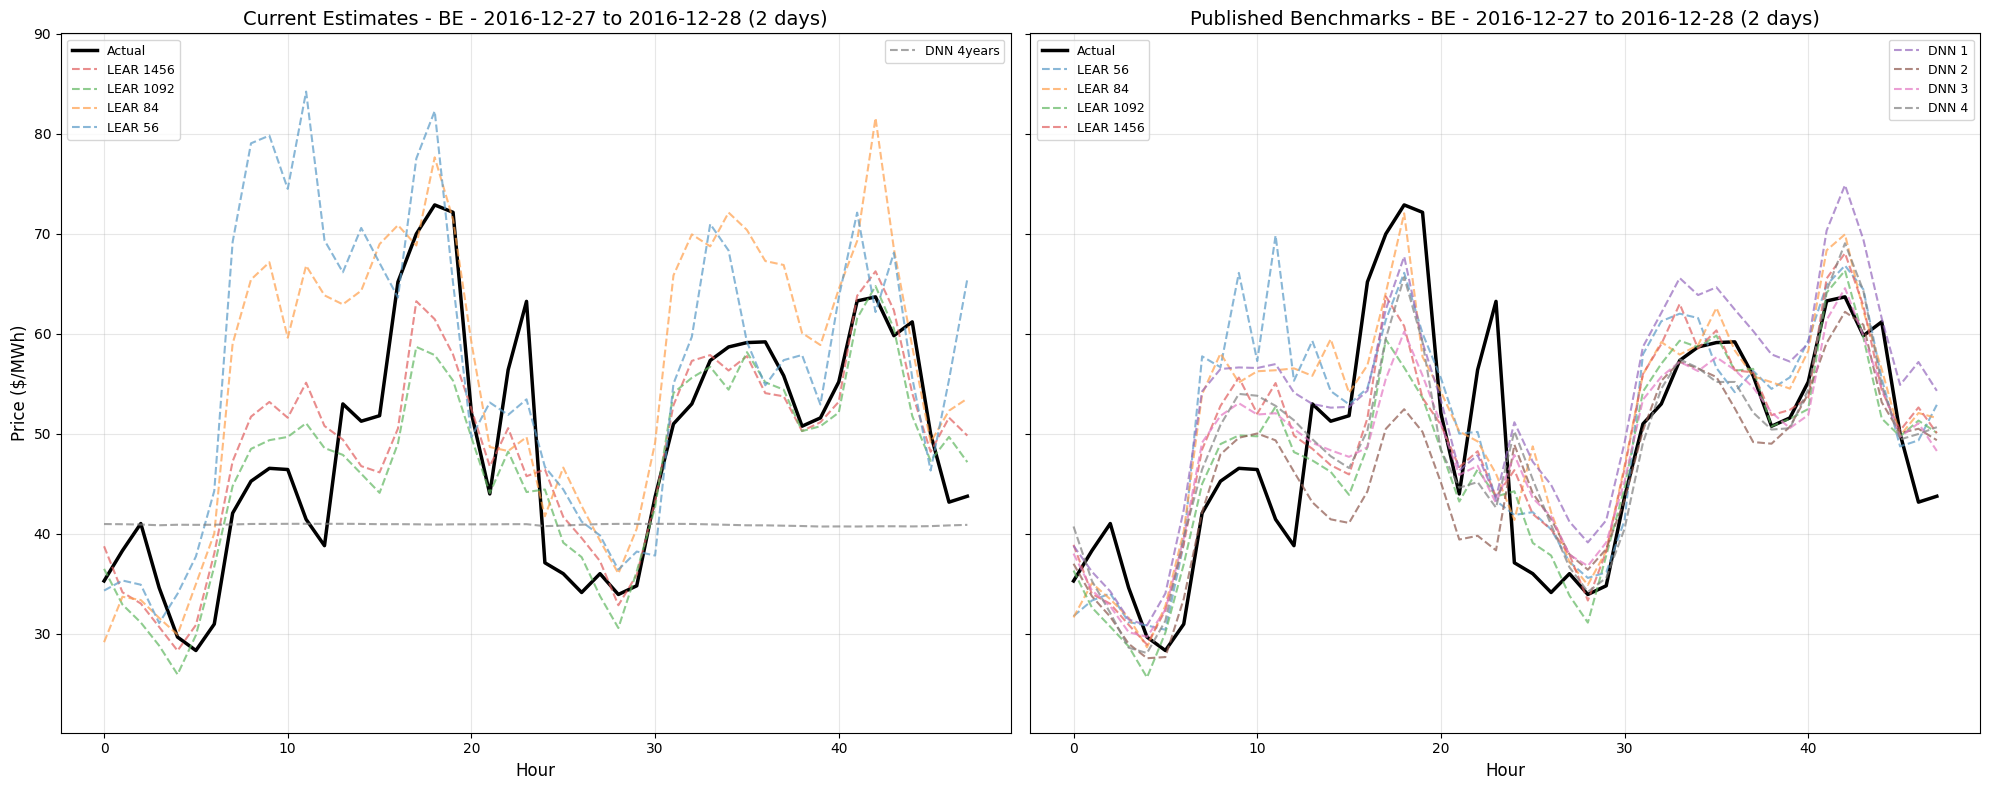

=== DE ===


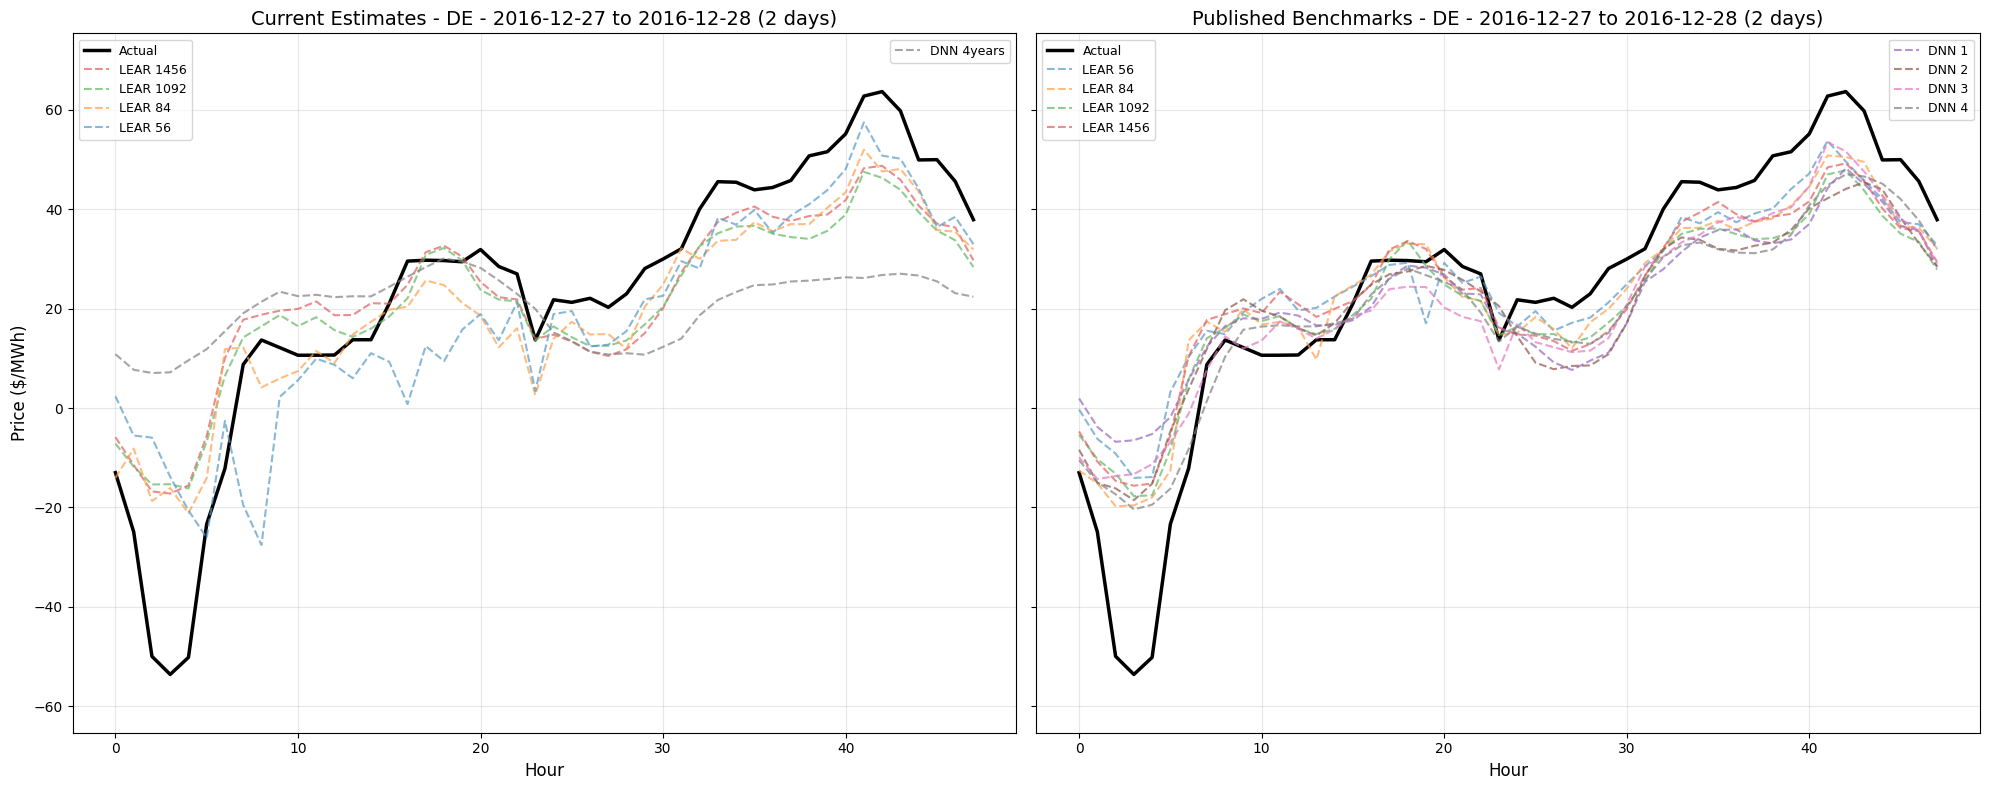

=== FR ===


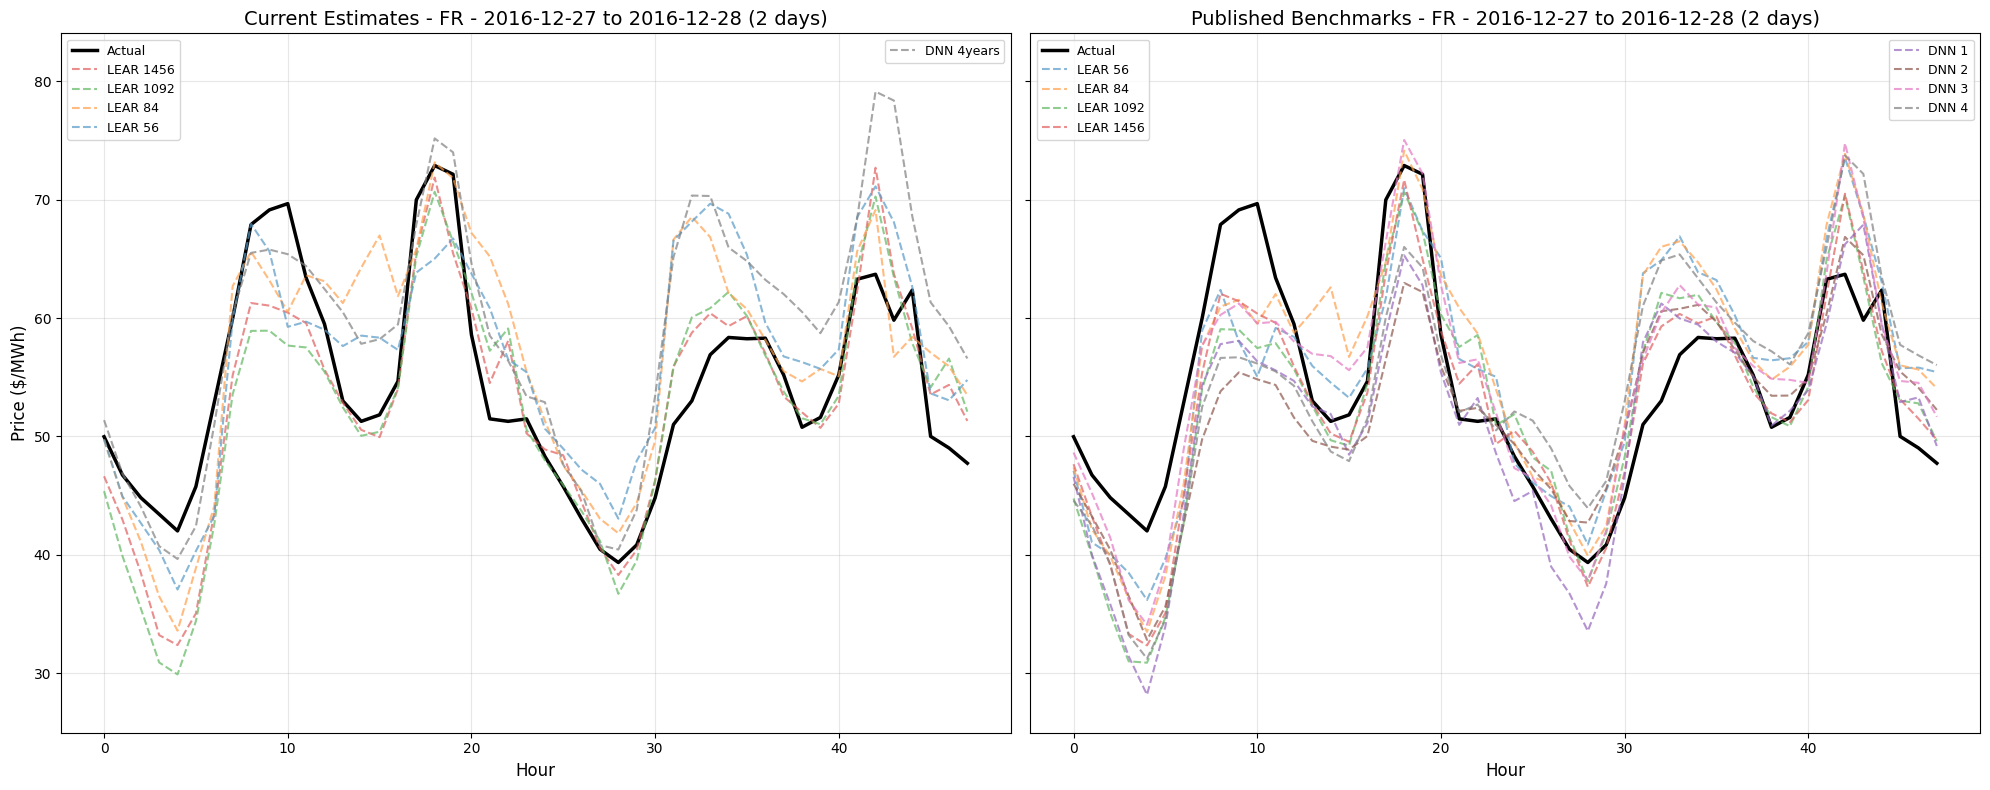

=== NP ===


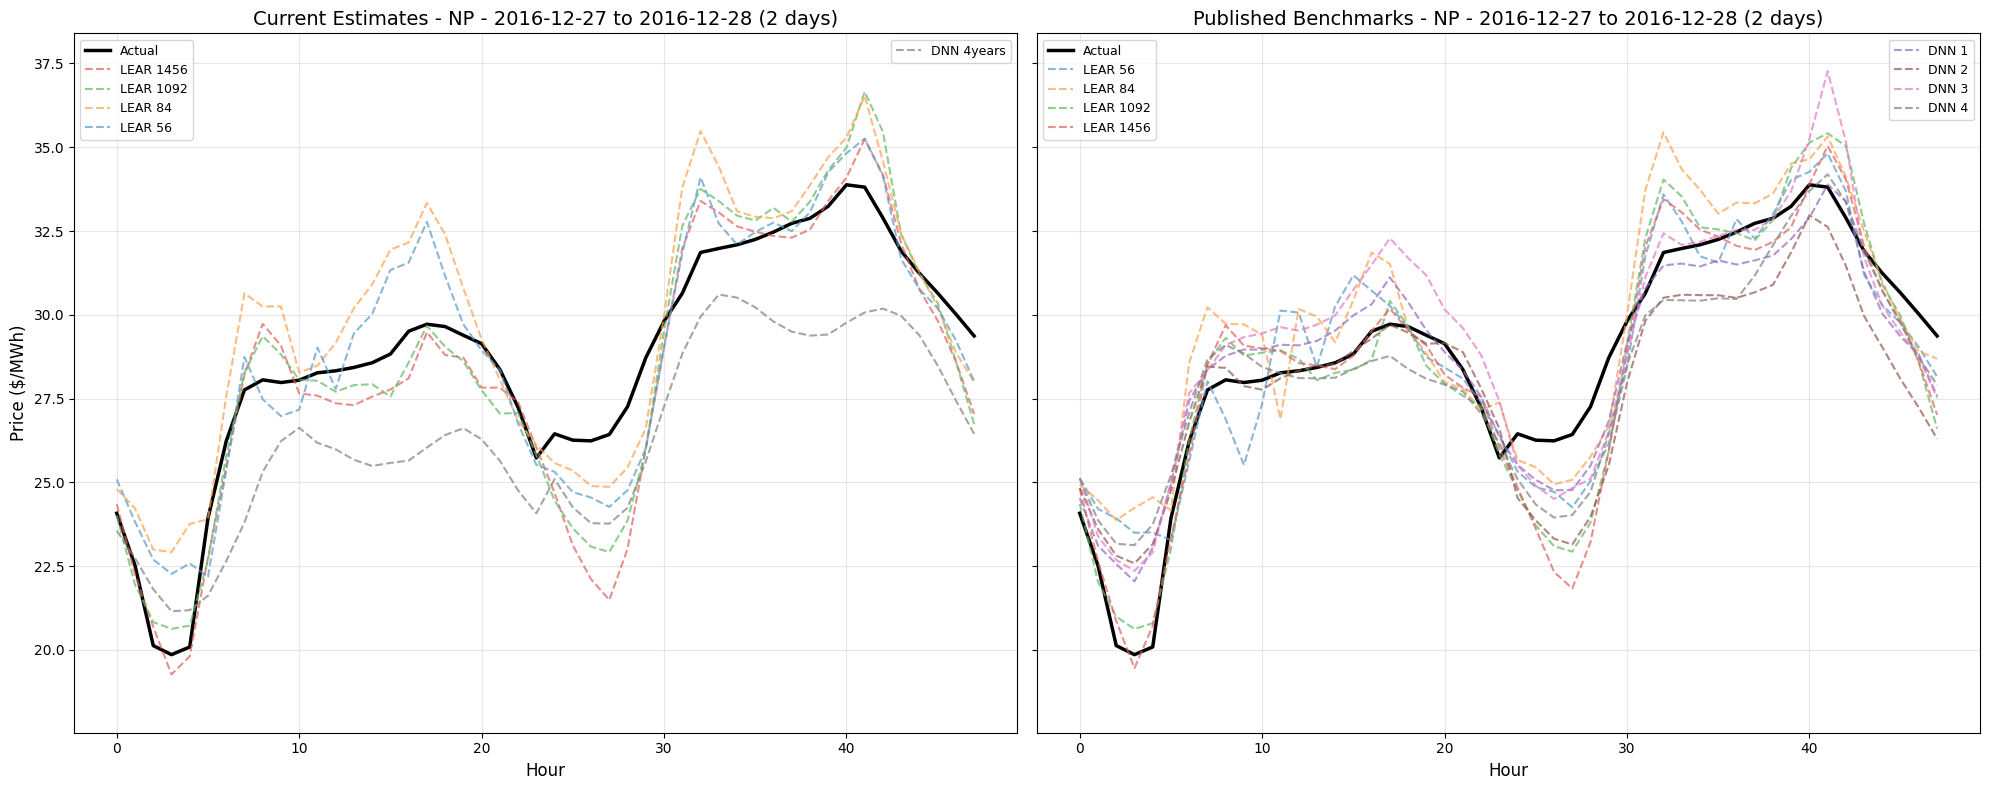

=== PJM ===


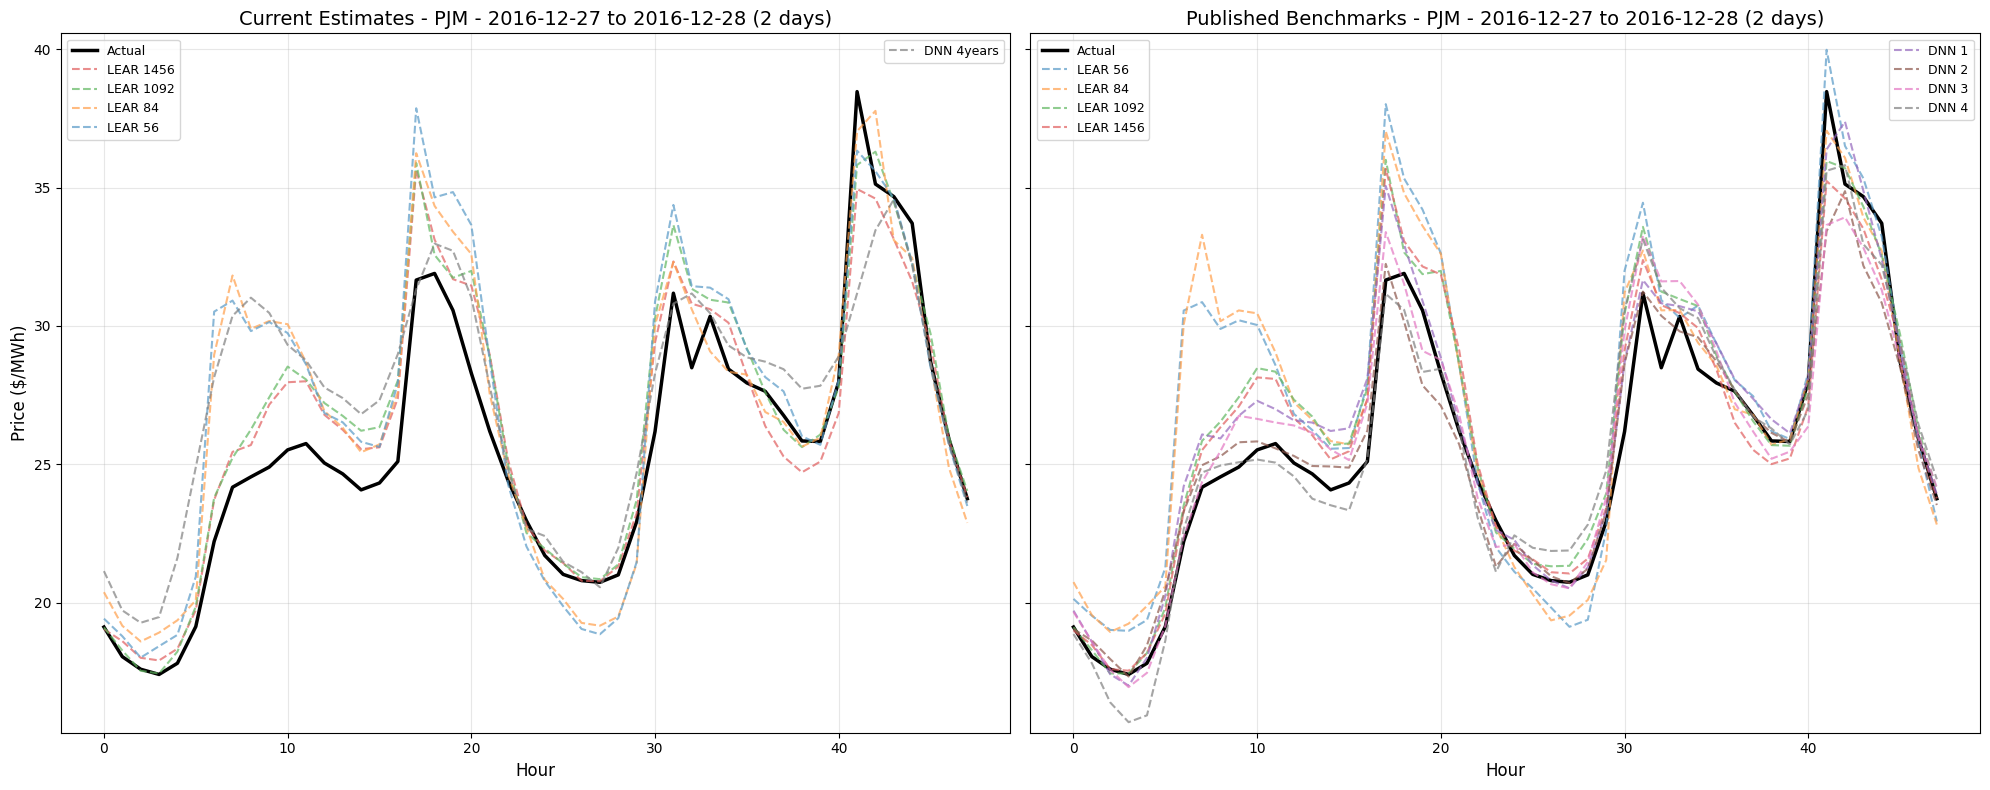

In [9]:
for market in MARKETS:
    print(f"=== {market} ===")
    benchmarks = published_benchmarks.get(market)
    plot_market_predictions(
        predictions=market_predictions[market],
        market=market,
        start_date=TARGET_START_DATE,
        end_date=TARGET_END_DATE,
        published_benchmarks=benchmarks,
        price_label='Price ($/MWh)',
    )
